In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

#%matplotlib inline
from functools import reduce
import re
import pymongo
from pandas.io.json import json_normalize

import folium
from folium import plugins

In [2]:
cliente = pymongo.MongoClient()

In [3]:
cliente.list_database_names()

['admin', 'companies_database', 'company', 'config', 'local', 'new_database']

In [4]:
db = cliente.company
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'company')

In [5]:
db.collection_names()

<ipython-input-5-8ff4d2505e25>:1: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  db.collection_names()


['company']

In [6]:
colec = db.company
colec

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'company'), 'company')

In [7]:
list(colec.find().limit(2))[0].keys()

dict_keys(['_id', 'name', 'permalink', 'crunchbase_url', 'homepage_url', 'blog_url', 'blog_feed_url', 'twitter_username', 'category_code', 'number_of_employees', 'founded_year', 'founded_month', 'founded_day', 'deadpooled_year', 'tag_list', 'alias_list', 'email_address', 'phone_number', 'description', 'created_at', 'updated_at', 'overview', 'image', 'products', 'relationships', 'competitions', 'providerships', 'total_money_raised', 'funding_rounds', 'investments', 'acquisition', 'acquisitions', 'offices', 'milestones', 'video_embeds', 'screenshots', 'external_links', 'partners'])

## Quiero fundar una empresa, por lo que comenzare a indagar sobre las categorias de las empresas fundadas del año 2000 en adelante que han recaudado mas ingresos donde el numero de empleados sea menor o igual a 2000 y en cuales ciudades tienen oficinas.

In [8]:
data = list(colec.find({'$and':[{'number_of_employees':{'$lte':2000}},{'founded_year':{'$gte':2000}}]},
                {'name':1,'number_of_employees':1,'founded_year':1,'_id':0,'total_money_raised':1, 'category_code':1}))

In [9]:
data_df=pd.DataFrame(data)
data_df

,name,category_code,number_of_employees,founded_year,total_money_raised
0,Wetpaint,web,47,2005,$39.8M
1,Zoho,software,1600,2005,$0
2,Digg,news,60,2004,$45M
3,Geni,web,18,2006,$16.5M
4,Twitter,social,1300,2006,$1.16B
...,...,...,...,...,...
7272,OfficialVirtualDJ,music,102,2009,€25M
7273,Eazeeloans,web,25,2006,$0
7274,DocASAP,web,7,2012,$800k
7275,cotralis,software,1,2008,$0


In [10]:
def string_to_numeric(string):
    if re.findall('M',string):
        return int(float(re.findall('\d+.\d+|\d', string)[0])*1000000)
    if re.findall('k',string):
        return int(float(re.findall('\d+.\d+|\d', string)[0])*1000)
    if re.findall('B',string):
        return int(float(re.findall('\d+.\d+|\d', string)[0])*1000000000)
    else:
        return int(re.findall('\d+', string)[0])

In [11]:
data_df['total_money_raised'] = data_df['total_money_raised'].apply(string_to_numeric)

In [12]:
data_df

,name,category_code,number_of_employees,founded_year,total_money_raised
0,Wetpaint,web,47,2005,39800000
1,Zoho,software,1600,2005,0
2,Digg,news,60,2004,4000000
3,Geni,web,18,2006,16500000
4,Twitter,social,1300,2006,1160000000
...,...,...,...,...,...
7272,OfficialVirtualDJ,music,102,2009,2000000
7273,Eazeeloans,web,25,2006,0
7274,DocASAP,web,7,2012,800000
7275,cotralis,software,1,2008,0


In [13]:
data_df = data_df.sort_values('total_money_raised', ascending=False)
data_df

,name,category_code,number_of_employees,founded_year,total_money_raised
4,Twitter,social,1300,2006,1160000000
499,Zynga,games_video,115,2007,860000000
473,Tesla Motors,automotive,500,2003,823000000
465,Deem,ecommerce,400,2000,467000000
4618,GREE,games_video,700,2004,464000000
...,...,...,...,...,...
3047,THE Movie Streamer,games_video,2,2008,0
3046,MYWEBBO,network_hosting,1,2008,0
3042,LastPass,security,8,2008,0
3040,Connective Logic,software,12,2004,0


In [14]:
data_df = data_df.drop_duplicates()
data_df.head(10)

,name,category_code,number_of_employees,founded_year,total_money_raised
4,Twitter,social,1300,2006,1160000000
499,Zynga,games_video,115,2007,860000000
473,Tesla Motors,automotive,500,2003,823000000
465,Deem,ecommerce,400,2000,467000000
4618,GREE,games_video,700,2004,464000000
7003,Bigpoint,games_video,500,2002,420000000
68,Box,network_hosting,950,2005,409000000
3136,TRUECar,transportation,303,2005,352000000
6397,Square,mobile,600,2009,341000000
6709,Sunrun,cleantech,180,2007,337000000


In [15]:
data_df = data_df.drop(data_df[data_df['total_money_raised']==0].index)
data_df

,name,category_code,number_of_employees,founded_year,total_money_raised
4,Twitter,social,1300,2006,1160000000
499,Zynga,games_video,115,2007,860000000
473,Tesla Motors,automotive,500,2003,823000000
465,Deem,ecommerce,400,2000,467000000
4618,GREE,games_video,700,2004,464000000
...,...,...,...,...,...
4084,Devkinetic Designs,web,1,2006,1000
5473,AuthorityLabs,search,3,2008,1000
6648,Carrier Mobile,mobile,0,2009,1000
669,Open Source Food,network_hosting,1,2007,1000


In [16]:
oficinas = colec.find({'offices':{'$not':{'$size':0}}},
                         {'name':True,'_id':0, 'offices':1})

In [17]:
oficinaP = list(colec.find({'$and':[{'number_of_employees':{'$lte':2000}},{'founded_year':{'$gte':2000}}]},
               {'name':True,'_id':0, 'offices':1}))

In [18]:
DF=pd.DataFrame(oficinaP)
DF

,name,offices
0,Wetpaint,"[{'description': '', 'address1': '710 - 2nd Av..."
1,Zoho,"[{'description': 'Headquarters', 'address1': '..."
2,Digg,"[{'description': None, 'address1': '135 Missis..."
3,Geni,"[{'description': 'Headquarters', 'address1': '..."
4,Twitter,"[{'description': '', 'address1': '1355 Market ..."
...,...,...
7272,OfficialVirtualDJ,"[{'description': 'Created in London', 'address..."
7273,Eazeeloans,"[{'description': 'Apex Finance & Marketing', '..."
7274,DocASAP,"[{'description': '', 'address1': '115 5th Ave'..."
7275,cotralis,[]


In [19]:
lista_ofic = [json_normalize(i) for i in DF['offices']]

<ipython-input-19-118d91ac5b6c>:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  lista_ofic = [json_normalize(i) for i in DF['offices']]


In [20]:
lista_ofic_name = list(DF['name'])

In [21]:
zip_ofic_df = list(zip(lista_ofic_name,lista_ofic))
zip_ofic_df


[('Wetpaint',
    description              address1    address2 zip_code      city state_code  \
  0                  710 - 2nd Avenue  Suite 1100    98104   Seattle         WA   
  1              270 Lafayette Street   Suite 505    10012  New York         NY   
  
    country_code   latitude   longitude  
  0          USA  47.603122 -122.333253  
  1          USA  40.723731  -73.996431  ),
 ('Zoho',
      description         address1   address2 zip_code        city state_code  \
  0  Headquarters  4900 Hopyard Rd  Suite 310    94588  Pleasanton         CA   
  
    country_code   latitude   longitude  
  0          USA  37.692934 -121.904945  ),
 ('Digg',
    description            address1 address2 zip_code           city state_code  \
  0        None  135 Mississippi St             94107  San Francisco         CA   
  
    country_code   latitude   longitude  
  0          USA  37.764726 -122.394523  ),
 ('Geni',
      description              address1 address2 zip_code            c

In [22]:
concat_df = pd.DataFrame()

In [23]:
for i in zip_ofic_df:
    i[1]['name'] = i[0]

In [24]:
for i in range(len(zip_ofic_df)):
    concat_df = pd.concat([concat_df,zip_ofic_df[i][1]])

In [25]:
concat_df

,description,address1,address2,zip_code,city,state_code,country_code,latitude,longitude,name
0,,710 - 2nd Avenue,Suite 1100,98104,Seattle,WA,USA,47.603122,-122.333253,Wetpaint
1,,270 Lafayette Street,Suite 505,10012,New York,NY,USA,40.723731,-73.996431,Wetpaint
0,Headquarters,4900 Hopyard Rd,Suite 310,94588,Pleasanton,CA,USA,37.692934,-121.904945,Zoho
0,None,135 Mississippi St,,94107,San Francisco,CA,USA,37.764726,-122.394523,Digg
0,Headquarters,9229 W. Sunset Blvd.,,90069,West Hollywood,CA,USA,34.090368,-118.393064,Geni
...,...,...,...,...,...,...,...,...,...,...
0,HQ,"Rue des Tanneurs, 60a",,1000,Brussels,None,BEL,50.839970,4.346472,Getyoo
0,Created in London,11 Eggleston view,,DL3 9SH,London,DC,GBR,NaN,NaN,OfficialVirtualDJ
0,Apex Finance & Marketing,"B 7/8,Sai Prasad CHS","N C Phadke Marg,Andheri east",400069,Mumbai,None,IND,NaN,NaN,Eazeeloans
0,,115 5th Ave,,10003,New York,NY,USA,NaN,NaN,DocASAP


In [26]:
df_cord = concat_df[['name','latitude','longitude','zip_code', 'city']]

In [27]:
df_cord

,name,latitude,longitude,zip_code,city
0,Wetpaint,47.603122,-122.333253,98104,Seattle
1,Wetpaint,40.723731,-73.996431,10012,New York
0,Zoho,37.692934,-121.904945,94588,Pleasanton
0,Digg,37.764726,-122.394523,94107,San Francisco
0,Geni,34.090368,-118.393064,90069,West Hollywood
...,...,...,...,...,...
0,Getyoo,50.839970,4.346472,1000,Brussels
0,OfficialVirtualDJ,NaN,NaN,DL3 9SH,London
0,Eazeeloans,NaN,NaN,400069,Mumbai
0,DocASAP,NaN,NaN,10003,New York


In [28]:
df_concatenado = pd.merge(data_df,df_cord)

In [29]:
df_concatenado

,name,category_code,number_of_employees,founded_year,total_money_raised,latitude,longitude,zip_code,city
0,Twitter,social,1300,2006,1160000000,37.776805,-122.416924,94103,San Francisco
1,Zynga,games_video,115,2007,860000000,37.765158,-122.404234,94103,San Francisco
2,Zynga,games_video,115,2007,860000000,NaN,NaN,,
3,Zynga,games_video,115,2007,860000000,NaN,NaN,,Baltimore
4,Zynga,games_video,115,2007,860000000,NaN,NaN,,Los Angeles
...,...,...,...,...,...,...,...,...,...
2592,Carrier Mobile,mobile,0,2009,1000,42.280271,-83.742233,48104,Ann Arbor
2593,Open Source Food,network_hosting,1,2007,1000,NaN,NaN,,Tokyo
2594,Saltlick Labs,mobile,3,2008,1000,30.415619,-97.801448,78750,Austin
2595,Saltlick Labs,mobile,3,2008,1000,-33.867139,151.207114,,Sydney


In [30]:
df_concatenado = df_concatenado.drop_duplicates()
df_concatenado

,name,category_code,number_of_employees,founded_year,total_money_raised,latitude,longitude,zip_code,city
0,Twitter,social,1300,2006,1160000000,37.776805,-122.416924,94103,San Francisco
1,Zynga,games_video,115,2007,860000000,37.765158,-122.404234,94103,San Francisco
2,Zynga,games_video,115,2007,860000000,NaN,NaN,,
3,Zynga,games_video,115,2007,860000000,NaN,NaN,,Baltimore
4,Zynga,games_video,115,2007,860000000,NaN,NaN,,Los Angeles
...,...,...,...,...,...,...,...,...,...
2592,Carrier Mobile,mobile,0,2009,1000,42.280271,-83.742233,48104,Ann Arbor
2593,Open Source Food,network_hosting,1,2007,1000,NaN,NaN,,Tokyo
2594,Saltlick Labs,mobile,3,2008,1000,30.415619,-97.801448,78750,Austin
2595,Saltlick Labs,mobile,3,2008,1000,-33.867139,151.207114,,Sydney


In [31]:
df_concatenado = df_concatenado.drop(df_concatenado[df_concatenado['latitude'].isnull()].index)
df_concatenado

,name,category_code,number_of_employees,founded_year,total_money_raised,latitude,longitude,zip_code,city
0,Twitter,social,1300,2006,1160000000,37.776805,-122.416924,94103,San Francisco
1,Zynga,games_video,115,2007,860000000,37.765158,-122.404234,94103,San Francisco
5,Tesla Motors,automotive,500,2003,823000000,37.496737,-122.245323,94304,Palo Alto
6,Deem,ecommerce,400,2000,467000000,37.559836,-122.271532,94105,San Francisco
11,Bigpoint,games_video,500,2002,420000000,53.597305,9.976252,20354,Hamburg
...,...,...,...,...,...,...,...,...,...
2591,Devkinetic Designs,web,1,2006,1000,42.454340,-71.066148,02176,Melrose
2592,Carrier Mobile,mobile,0,2009,1000,42.280271,-83.742233,48104,Ann Arbor
2594,Saltlick Labs,mobile,3,2008,1000,30.415619,-97.801448,78750,Austin
2595,Saltlick Labs,mobile,3,2008,1000,-33.867139,151.207114,,Sydney


## Categorias con mas dinero recaudado.

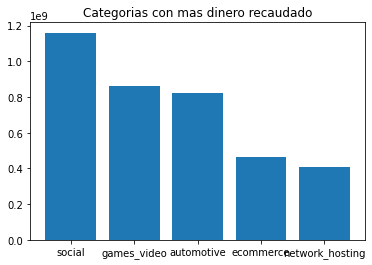

In [47]:

x = data_df['category_code'].head(7)
y = data_df['total_money_raised'].head(7)
plt.bar(x,y)
plt.title('Categorias con mas dinero recaudado')
plt.savefig('Categorias con mas dinero recaudado.png',bbox_inches='tight');

## Las Categorias mas comunes fundadas a partir del 2010

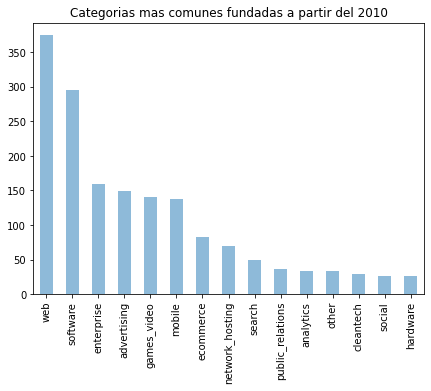

In [33]:
data_df['category_code'].value_counts().head(15).plot(kind='bar',alpha = 0.5, figsize=(7,5))
plt.title('Categorias mas comunes fundadas a partir del 2010')
plt.savefig('Categorias mas comunes fundadas a partir del 2010.png',bbox_inches='tight');

## De acuerdo a que hay se han creado mas empresas de web y software y a consideracion de valores a las de software les ha ido bien elegire como tipo de categoria Software para empresa.

## Top 10 Ciudades con la mayor cantidad de empresas Nuevas

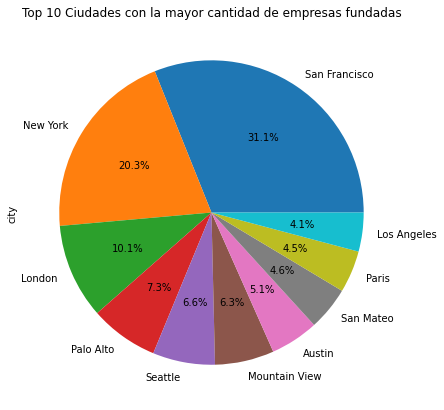

In [48]:
df_concatenado['city'].value_counts().head(10).plot(kind = 'pie', figsize=(15,7),autopct='%1.1f%%')
plt.title('Top 10 Ciudades con la mayor cantidad de empresas fundadas')
plt.savefig('Top 10 Ciudades con la mayor cantidad de empresas Nuevas.png',bbox_inches='tight');

In [35]:
df_concatenado[df_concatenado['category_code']=='software']['city'].value_counts()[:15]

San Francisco    17
New York         12
Austin            9
San Mateo         8
London            8
Santa Clara       7
Cambridge         7
Seattle           6
San Jose          5
Palo Alto         5
Redwood City      5
Burlington        4
Chicago           4
Sunnyvale         4
Amsterdam         4
Name: city, dtype: int64

In [36]:
city= ['San Francisco', 'New York', 'Austin', 'San Mateo', 'London', 'Santa Clara']

In [51]:
def city_category(city, cat):
    df_concatenado[df_concatenado['category_code']==f'{cat}'][df_concatenado['city']== f'{city}'].groupby('founded_year')['name'].count().plot(figsize=(12,6))
    plt.title(f'Empresas de Software creadas en distintas ciudades');

<ipython-input-51-57d3f8b24cc9>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_concatenado[df_concatenado['category_code']==f'{cat}'][df_concatenado['city']== f'{city}'].groupby('founded_year')['name'].count().plot(figsize=(12,6))
<ipython-input-51-57d3f8b24cc9>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_concatenado[df_concatenado['category_code']==f'{cat}'][df_concatenado['city']== f'{city}'].groupby('founded_year')['name'].count().plot(figsize=(12,6))
<ipython-input-51-57d3f8b24cc9>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_concatenado[df_concatenado['category_code']==f'{cat}'][df_concatenado['city']== f'{city}'].groupby('founded_year')['name'].count().plot(figsize=(12,6))
<ipython-input-51-57d3f8b24cc9>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_concatenado[df_concatenado['category_code']==f'{cat}'][df_concatenado['city']== 

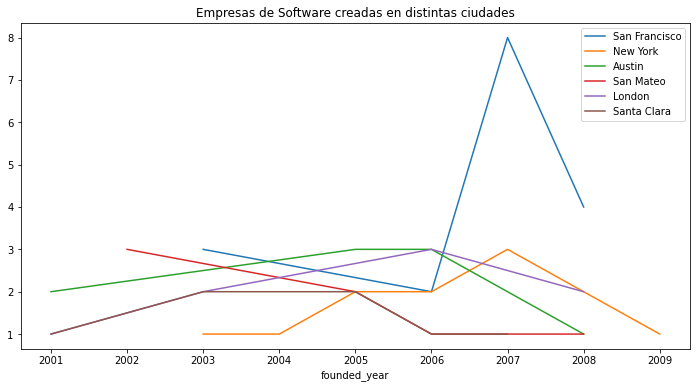

In [52]:
for i in city:
    city_category(i, 'software')
    plt.legend(city)
    plt.savefig('Empresas de Software a lo largo del tiempo.png',bbox_inches='tight');

## Aunque hay un decrecimiento de fundacion de empresas de software en San Francisco a partir del 2007  (se deberia indagar el motivo) es donde se fundaron la mayor cantidad de empresas por lo que tomare esta ciudad para fundar mi empresa de software.

In [39]:
df_Resumen =df_concatenado[(df_concatenado['total_money_raised'] == 'software') & (df_concatenado['city']=='San Francisco')]

In [40]:
df_Resumen.head(2)

,name,category_code,number_of_employees,founded_year,total_money_raised,latitude,longitude,zip_code,city


In [66]:
df_cord =df_Resumen[['latitude','longitude','name']]

In [76]:

mapa2=folium.Map(location=[37.773972, -122.431297], TileLayer='stamentoner', zoom_start=13)
lat=list(df_Resumen['latitude'])
lng=list(df_Resumen['longitude'])
nom=list(df_Resumen['name'])


## En el siguiente mapa ubico la zona en especifico donde ubicare mi empresa de software en San Francisco y muestro mi posible competencia o posibles socios.

In [77]:

for i in range(len(lat)):
    folium.Marker([lat[i], lng[i]], icon=folium.Icon(color='red'),popup = '<b>Software!!</b>', tooltip = (nom[i])).add_to(mapa2)

mapa2



In [44]:
df_Res =df_concatenado[(df_concatenado['total_money_raised'] > 1000000) & (df_concatenado['city']=='San Francisco')]

In [45]:
mapa3=folium.Map(location=[37.773972, -122.431297], TileLayer='mapquestopen', zoom_start=15)
lat1=list(df_Res['latitude'])
lng1=list(df_Res['longitude'])
cat=list(df_Res['category_code'])

## Categorias de empresas que han recaudado mas de $1M en San Francisco cerca de donde ubicare la empresa de software

In [63]:
for i in range(len(lat1)):
    folium.Marker([lat1[i], lng1[i]], icon=folium.Icon(color='blue'),popup = '<b>Software!!</b>', tooltip = (cat[i])).add_to(mapa3)
    
mapa3

In [58]:
mapa3.save('mapa3.html')